In [1]:
import math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import numba
from numba import njit
import time
from matplotlib.pyplot import figure
# !pip install ortools
# import ortools

# from ortools.constraint_solver import routing_enums_pb2

# from ortools.constraint_solver import pywrapcp
from numba.typed import List
from collections import defaultdict
figure(figsize=(8, 6), dpi=80)

import matplotlib.colors as mcolors


<Figure size 640x480 with 0 Axes>

In [2]:
item_list  = []
PI_LENGTH = 0
PI_WIDTH = 1
PI_HEIGHT = 2
PI_QTY = 3
PI_X = 4
PI_Y = 5
PI_Z = 6
PI_ITEM_INDEX = 71
PI_REQ_INDEX = 8
PI_ROTATION = 9
PI_LOADING_INDEX = 10

bin_width=500
bin_length=700
current_x=0
current_y=0
for i in range(100):
    l= rd.randint(40,60)
    w= rd.randint(40,60)
    h= rd.randint(40,60)

    q= 1
    if current_y+w> bin_width:
        current_x+=60
        current_y=0
    pos_x= current_x
    pos_y= current_y
    current_y+=w
    pos_z= 0

    item_list.append(np.array([l,w,h,q,pos_x, pos_y, pos_z, i,i,0,0]))
item_list= np.array(item_list, np.int_)

def generate_random_colors(num_colors):
    colors = []
    for i in range(num_colors):
        color = rd.choice(list(mcolors.CSS4_COLORS.values()))
        colors.append(color)
    return colors
# generate_random_colors(50)

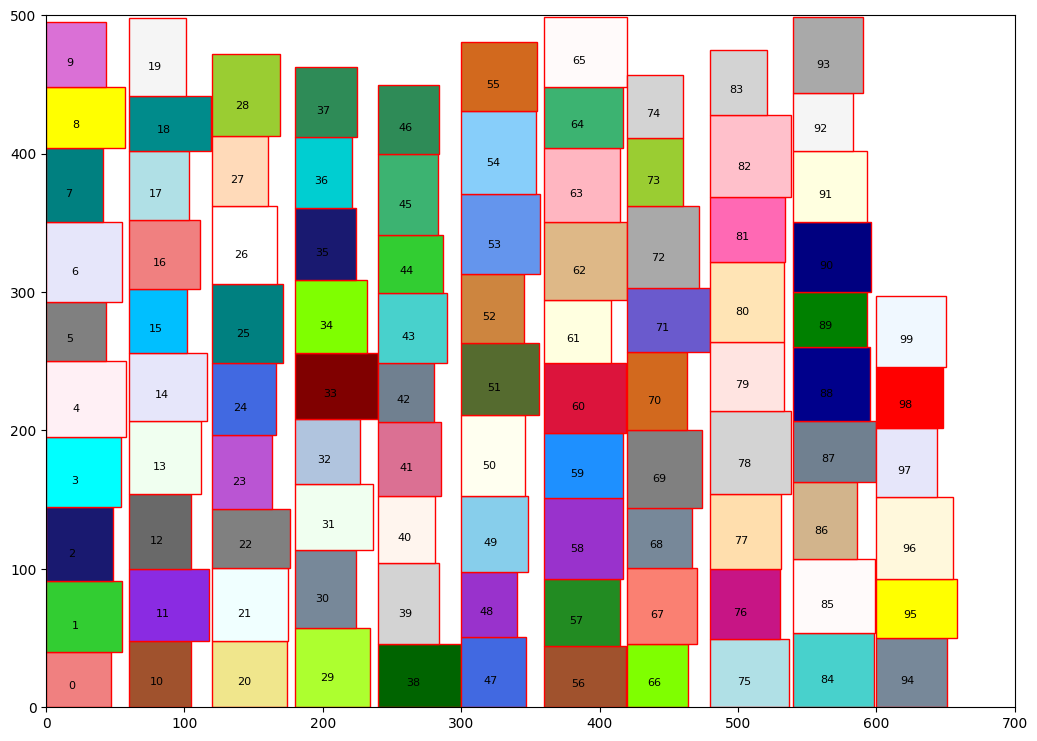

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

color_list =    generate_random_colors(500)
def visualize(item_list, bin_width, bin_length):
    fig, ax = plt.subplots(1, 1, figsize=(bin_width / 40, bin_length / 40))

    # color_list = ['r', ]
    ax.set_xlim([0, bin_length])
    ax.set_ylim([0,bin_width ])
    ax.set_aspect('equal', adjustable='box')
    for j in range(len(item_list)):
        item= item_list[j]
        x, y, w, l = item[PI_X], item[PI_Y], item[PI_LENGTH], item[PI_WIDTH]
        rect = Rectangle((x, y), w, l, linewidth=1, edgecolor='r', facecolor= color_list[ j %len(color_list) ] )
        ax.add_patch(rect)
        plt.text(x+w/3,y+l/3,str(j), fontsize=8   )
    # plt.text(100, 100, "cost "+str(cost_packing(item_list)  ))
    plt.show()
visualize(item_list, bin_width, bin_length)

In [4]:
@njit
def check_over_lap(p1,y1, p2, y2):
    if p1>=p2+y2:
        return False
    if p1+y1<=p2:
        return False
    return True

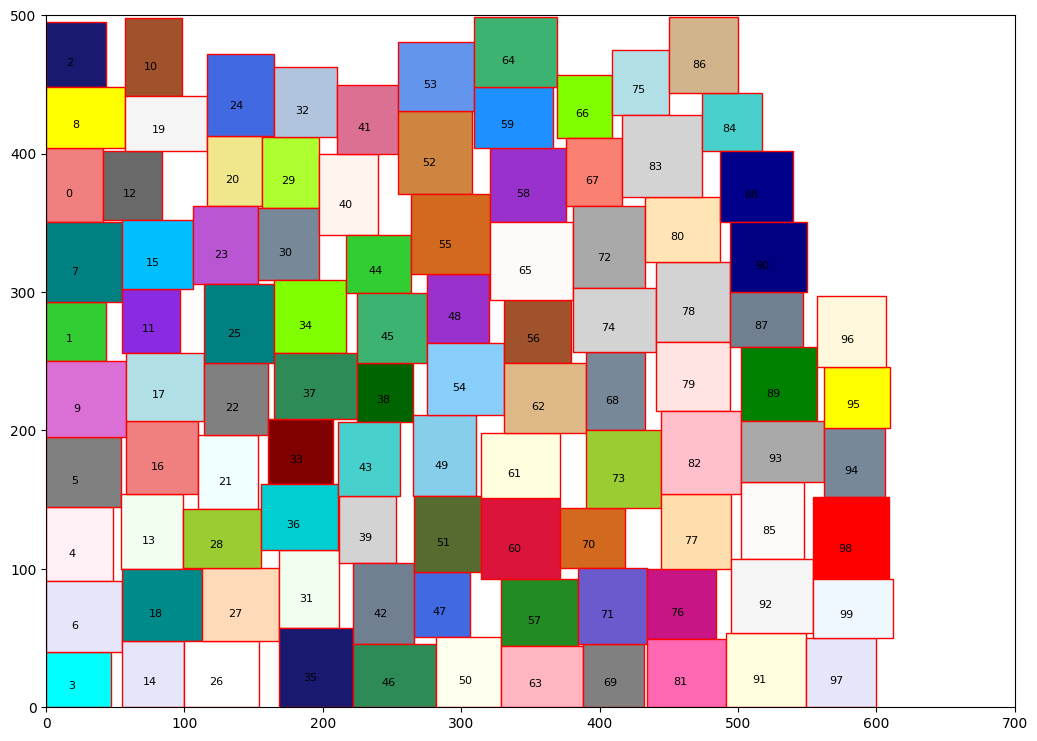

In [5]:
@njit
def shaking_items(item_list, invert, shaking_direction, shaking_zone, static_zone):
    if not invert:item_list = item_list[np.argsort(item_list[:,PI_LENGTH + shaking_direction] + item_list[:,PI_X + shaking_direction])]
    elif invert: item_list = item_list[np.argsort(-item_list[:,PI_LENGTH + shaking_direction] - item_list[:,PI_X + shaking_direction])]
    for i in range(len(item_list)):
        if item_list[i][PI_X] < shaking_zone[PI_X] or item_list[i][PI_X] > shaking_zone[PI_X] + shaking_zone[PI_LENGTH] or item_list[i][PI_Y] < shaking_zone[PI_Y] or item_list[i][PI_Y] > shaking_zone[PI_Y] + shaking_zone[PI_WIDTH]:
          continue
        if item_list[i][PI_X] >= static_zone[PI_X] and item_list[i][PI_X] <= static_zone[PI_X] + static_zone[PI_LENGTH] and item_list[i][PI_Y] >= static_zone[PI_Y] and item_list[i][PI_Y] <= static_zone[PI_Y] + static_zone[PI_WIDTH]:
          continue
        if not invert: new_pos=0
        elif invert:
          if shaking_direction == 0:
            new_pos = bin_length  - item_list[i][PI_LENGTH]
          elif shaking_direction == 1:
            new_pos = bin_width  - item_list[i][PI_WIDTH]
        for j in range(i):
            if not invert:
              if check_over_lap(item_list[i][PI_Y - shaking_direction],item_list[i][PI_WIDTH - shaking_direction], item_list[j][PI_Y - shaking_direction],item_list[j][PI_WIDTH - shaking_direction]):
                  new_pos= max(item_list[j][PI_X + shaking_direction]+ item_list[j][PI_LENGTH + shaking_direction], new_pos)
            elif invert:
              if check_over_lap(item_list[i][PI_Y - shaking_direction],item_list[i][PI_WIDTH - shaking_direction], item_list[j][PI_Y - shaking_direction],item_list[j][PI_WIDTH - shaking_direction]):
                  new_pos= min(item_list[j][PI_X + shaking_direction]- item_list[i][PI_LENGTH + shaking_direction], new_pos)
        item_list[i][PI_X + shaking_direction]= new_pos
    return item_list
item_list= shaking_items(item_list, 0, 0, np.array([10000000, 10000000, 0, 0, 0, 0]), np.array([0, 0, 0, 0, -1, -1], np.int_))
visualize(item_list, bin_width, bin_length)